# _Moneyballing Fantasy Premier League Football_
# Points Origins

So far, we have focussed a lot on shots, goals, and assists - this is presumably a significant source of points in FPL.

Of course, it would be nice to know for sure...

### Import standard libraries...

In [1]:
#Standard data manipulations
import pandas as pd
import numpy as np

#SQL
import sqlite3
#Including custom functions, stored elsewhere in the repo
from PythonFunctions.sqlfunctions import *

#For getting JSON files from FPL
import requests

#Data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#Import custom visuals settings
from PythonFunctions.cb91visuals import *

#Suppress warnings from showing
import warnings
warnings.filterwarnings('ignore')

### Exploring the API

The data that we need is available from the FPL API, though it will require some manipulation to get there.

In [2]:
def EventAPI(event):
    '''
    Takes match week, and returns the
    API JSON file associated with the
    player performance in that week.
    '''
    
    url = f'https://fantasy.premierleague.com/api/event/{event}/live/'    
    return requests.get(url).json()

We can see from a sample json file that we have a list of player dictionaries, with each one looking as follows:

In [3]:
test_event = EventAPI(1)['elements']
test_event[0]

{'id': 14,
 'stats': {'minutes': 90,
  'goals_scored': 0,
  'assists': 0,
  'clean_sheets': 1,
  'goals_conceded': 0,
  'own_goals': 0,
  'penalties_saved': 0,
  'penalties_missed': 0,
  'yellow_cards': 0,
  'red_cards': 0,
  'saves': 2,
  'bonus': 1,
  'bps': 27,
  'influence': '18.0',
  'creativity': '0.0',
  'threat': '0.0',
  'ict_index': '1.8',
  'total_points': 7,
  'in_dreamteam': False},
 'explain': [{'fixture': 10,
   'stats': [{'identifier': 'minutes', 'points': 2, 'value': 90},
    {'identifier': 'clean_sheets', 'points': 4, 'value': 1},
    {'identifier': 'bonus', 'points': 1, 'value': 1}]}]}

The data we need here is the 'id' to work out what position the player is (we can refer back to a player table from our existing sql database), and the 'stats' within the 'explain' dictionary, which tells us how they're scoring points.

In [4]:
test_event[0]['explain'][0]['stats']

[{'identifier': 'minutes', 'points': 2, 'value': 90},
 {'identifier': 'clean_sheets', 'points': 4, 'value': 1},
 {'identifier': 'bonus', 'points': 1, 'value': 1}]

Let's bring in the player table.

In [5]:
#Create the database 'fpl.db' (fantasy premier league!)
conn = sqlite3.connect('Data/fpl.db')
#Instantiate a cursor
cur = conn.cursor()
df_players = sql('select * from PlayersBasic', cur)
df_players.head()

,PlayerID,PlayerCode,FirstName,WebName,Team,Position,CommentName
PlayersBasicID,,,,,,,
1,1,69140,Shkodran,Mustafi,Arsenal,DEF,Shkodran Mustafi
2,2,98745,Hector,Bellerin,Arsenal,DEF,Hector Bellerin
3,3,111457,Sead,Kolasinac,Arsenal,DEF,Sead Kolasinac
4,4,154043,Ainsley,Maitland-Niles,Arsenal,DEF,Ainsley Maitland-Niles
5,5,39476,Sokratis,Sokratis,Arsenal,DEF,Sokratis


We can make a quick function that will return the player position (Goalkeeper, Defender, etc.) of a given PlayerID.

In [6]:
def id_position(x):
    return df_players.loc[df_players['PlayerID']==x, 'Position'].item()

### Building out the data

We'll build out this data as a series of nested dictionaries. We'll start with a dictionary for each position, with a structure like this:

`{'clean_sheets':{'points':x, 'value':y}, minutes_played:{'points':x, 'value':y}, ...}`

In [7]:
points_dict = {'GKP':{}, 'DEF':{}, 'MID':{}, 'FWD':{}}

#Iterate through the different gameweeks
for gameweek in range(1,30):
    #Get the json file for each gameweek
    json_file = EventAPI(gameweek)['elements']
    
    #Iterate through the players in each json file
    for player in json_file:
        #Get the player's position
        pos = id_position(player['id'])

        #Get the player stats from the json
        explain = player['explain']
        
        #Check if it's non-blank
        if len(explain) == 0:
            continue
        else:
            stats = explain[0]['stats']
            #For each type of stat
            for stat in stats:
                #Get the name of the stat, the points earned
                #and the frequency/value
                event = stat['identifier']
                points = stat['points']
                value = stat['value']

                #Check if the event already exists in the position
                if points_dict[pos].get(event, 'NA') == 'NA':
                    #If not, create it
                    points_dict[pos][event] = {'points':points,
                                             'value':value}
                #Otherwise, just add it to the exitsting KV pair
                else:
                    points_dict[pos][event]['points'] += points
                    points_dict[pos][event]['value'] += value

In [8]:
points_dict

{'GKP': {'minutes': {'points': 1155, 'value': 51648},
  'clean_sheets': {'points': 600, 'value': 150},
  'bonus': {'points': 174, 'value': 174},
  'saves': {'points': 393, 'value': 1401},
  'goals_conceded': {'points': -260, 'value': 584},
  'penalties_saved': {'points': 70, 'value': 14},
  'yellow_cards': {'points': -23, 'value': 23},
  'assists': {'points': 9, 'value': 3},
  'own_goals': {'points': -8, 'value': 4},
  'red_cards': {'points': -6, 'value': 2}},
 'DEF': {'minutes': {'points': 4963, 'value': 213428},
  'assists': {'points': 480, 'value': 160},
  'clean_sheets': {'points': 2496, 'value': 624},
  'bonus': {'points': 557, 'value': 557},
  'goals_conceded': {'points': -1058, 'value': 2370},
  'yellow_cards': {'points': -414, 'value': 414},
  'goals_scored': {'points': 618, 'value': 103},
  'own_goals': {'points': -28, 'value': 14},
  'red_cards': {'points': -54, 'value': 18},
  'penalties_missed': {'points': -2, 'value': 1}},
 'MID': {'minutes': {'points': 5920, 'value': 2318

This looks interesting - let's try and get it into a dataframe so that we can more easily visualise it.

In [9]:
unique_events = []

for i in list(points_dict.keys()):
    unique_events.extend(list(points_dict[i].keys()))
    
unique_events = list(set(unique_events))

In [10]:
#Instantiate a blank dataframe with an index of unique events
df = pd.DataFrame(index=unique_events)

#For each position, populate with the points
positions = ['GKP', 'DEF', 'MID', 'FWD']
for pos in positions:
    position_points = {i:[points_dict[pos].get(i,{'points': 0,'value': 0})]
                       for i in unique_events}
    
    new_col = pd.DataFrame(position_points).T
    new_col.columns = [pos]
    
    df = pd.concat([df, new_col], axis=1)

In [11]:
df

,GKP,DEF,MID,FWD
yellow_cards,"{'points': -23, 'value': 23}","{'points': -414, 'value': 414}","{'points': -479, 'value': 479}","{'points': -95, 'value': 95}"
red_cards,"{'points': -6, 'value': 2}","{'points': -54, 'value': 18}","{'points': -36, 'value': 12}","{'points': -9, 'value': 3}"
goals_scored,"{'points': 0, 'value': 0}","{'points': 618, 'value': 103}","{'points': 1775, 'value': 355}","{'points': 1192, 'value': 298}"
goals_conceded,"{'points': -260, 'value': 584}","{'points': -1058, 'value': 2370}","{'points': 0, 'value': 0}","{'points': 0, 'value': 0}"
bonus,"{'points': 174, 'value': 174}","{'points': 557, 'value': 557}","{'points': 644, 'value': 644}","{'points': 461, 'value': 461}"
saves,"{'points': 393, 'value': 1401}","{'points': 0, 'value': 0}","{'points': 0, 'value': 0}","{'points': 0, 'value': 0}"
penalties_missed,"{'points': 0, 'value': 0}","{'points': -2, 'value': 1}","{'points': -16, 'value': 8}","{'points': -14, 'value': 7}"
minutes,"{'points': 1155, 'value': 51648}","{'points': 4963, 'value': 213428}","{'points': 5920, 'value': 231879}","{'points': 1880, 'value': 68812}"
clean_sheets,"{'points': 600, 'value': 150}","{'points': 2496, 'value': 624}","{'points': 714, 'value': 714}","{'points': 0, 'value': 0}"
own_goals,"{'points': -8, 'value': 4}","{'points': -28, 'value': 14}","{'points': -10, 'value': 5}","{'points': -4, 'value': 2}"


In [12]:
df_points = df.copy()
for col in df_points.columns:
    df_points[col] = df_points[col].map(lambda x: x['points'])
df_points['Total'] = df_points.sum(axis=1)

df_points

,GKP,DEF,MID,FWD,Total
yellow_cards,-23,-414,-479,-95,-1011
red_cards,-6,-54,-36,-9,-105
goals_scored,0,618,1775,1192,3585
goals_conceded,-260,-1058,0,0,-1318
bonus,174,557,644,461,1836
saves,393,0,0,0,393
penalties_missed,0,-2,-16,-14,-32
minutes,1155,4963,5920,1880,13918
clean_sheets,600,2496,714,0,3810
own_goals,-8,-28,-10,-4,-50


Let's start visualising this data.

Firstly, a comparison of the number of players in the game by position, and the overall points by position.

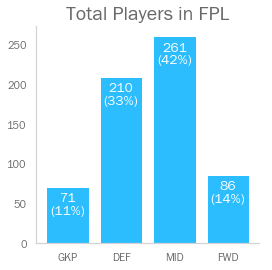

In [13]:
X = df_points.columns[:-1]
Y = [df_players.groupby('Position').count()['PlayerID'][i] for i in X]

plt.figure(figsize=(4,4))

plt.bar(X,Y)
plt.title('Total Players in FPL')
for i, t in enumerate(Y):
    text = f'{t}\n({int(round(100*t/sum(Y)))}%)'
    plt.text(i, t-35, text, ha='center', color='white', fontsize=14);

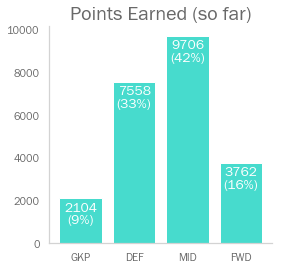

In [22]:
X = df_points.columns[:-1]
Y = df_points.sum()[:-1]

plt.figure(figsize=(4,4))

plt.bar(X,Y,color=CB91_Green)
plt.title('Points Earned (so far)')
for i, t in enumerate(Y):
    text = f'{t}\n({round(100*t/sum(Y))}%)'
    plt.text(i, t-1200, text, ha='center', color='white', fontsize=14);

So it seems like points are actually quite well distributed amongst the different positions.

However, forwards do seem like better points generators when we exclude the points gained for simply playing minutes.

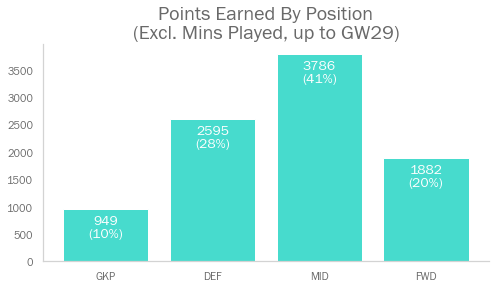

In [15]:
X = df_points.columns[:-1]
Y = (df_points.sum() - df_points.loc['minutes'])[:-1]

plt.figure(figsize=(8,4))

plt.bar(X,Y,color=CB91_Green)
plt.title('Points Earned By Position\n(Excl. Mins Played, up to GW29)')
for i, t in enumerate(Y):
    text = f'{t}\n({round(100*t/sum(Y))}%)'
    plt.text(i, t-500, text, ha='center', color='white', fontsize=14);

Defenders get a bit of a raw deal in terms of negative points. Though all positions can lose points for yellow and red cards (as well as missing penalties), defenders and goalkeepers also lose points for conceding more than 2 goals.

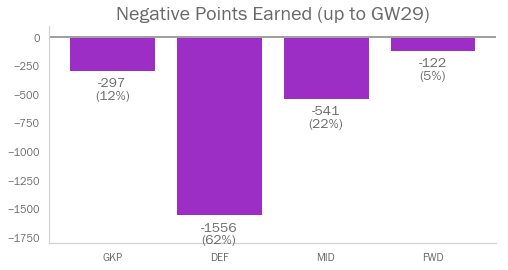

In [16]:
df_neg = df_points.loc[df_points['Total']<0]

X = df_neg.columns[:-1]
Y = df_neg.sum()[:-1]

plt.figure(figsize=(8,4))

plt.axhline(0, color='grey')
plt.bar(X,Y,color=CB91_Purple)
plt.ylim(-1800,100)

plt.title('Negative Points Earned (up to GW29)')

for i, t in enumerate(Y):
    text = f'{t}\n({round(100*t/sum(Y))}%)'
    plt.text(i, t-250, text, ha='center', color='dimgrey', fontsize=14);

What about where points come from?

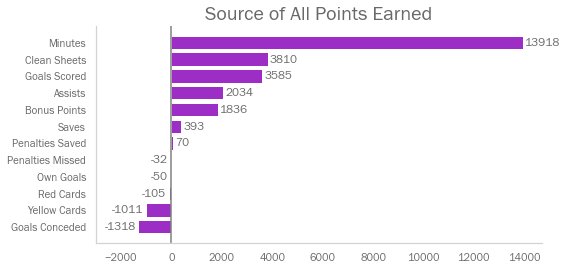

In [30]:
df_temp = df_points.sort_values('Total')['Total']

X = df_temp.index
Y = df_temp

plt.figure(figsize=(8,4))

plt.axvline(0, color='grey')
plt.barh(X,Y,color=CB91_Purple)
plt.xlim(-3000,)

plt.title('Source of All Points Earned')

for i, t in enumerate(Y):
    text = f'{t}'
    if t>0:
        plt.text(t+100, i, text, va='center',
                 color='dimgrey', fontsize=12)
    else:
        plt.text(t-100, i, text, va='center', ha='right',
                 color='dimgrey', fontsize=12)
        
plt.yticks(range(12),
           ['Minutes','Clean Sheets','Goals Scored','Assists','Bonus Points',
           'Saves','Penalties Saved', 'Penalties Missed', 'Own Goals',
           'Red Cards', 'Yellow Cards', 'Goals Conceded'][::-1]);

Evidently, most points are scored through just turning up to play...

Let's remove this bar, and rescale the graph.

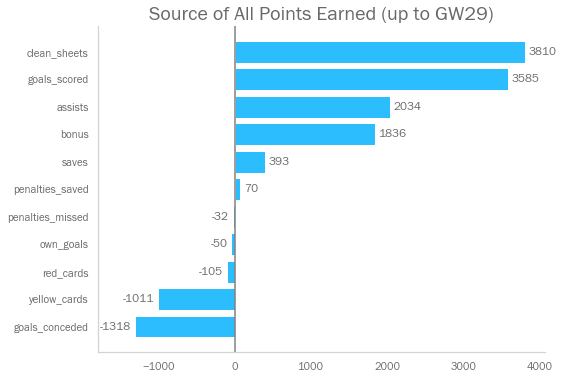

In [18]:
df_temp = df_points.sort_values('Total')['Total'][:-1]

X = df_temp.index
Y = df_temp

plt.figure(figsize=(8,6))

plt.axvline(0, color='grey')
plt.barh(X,Y)
plt.xlim(-1800,)

plt.title('Source of All Points Earned (up to GW29)')

for i, t in enumerate(Y):
    text = f'{t}'
    if t>0:
        plt.text(t+50, i, text, va='center',
                 color='dimgrey', fontsize=12)
    else:
        plt.text(t-50, i, text, va='center', ha='right',
                 color='dimgrey', fontsize=12)

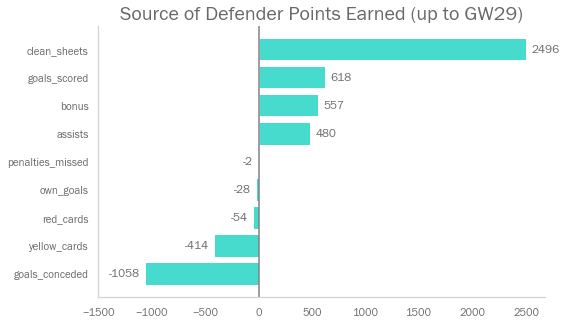

In [19]:
df_temp = df_points.sort_values('DEF')['DEF'][:-1]
df_temp = df_temp[df_temp!=0]

X = df_temp.index
Y = df_temp

plt.figure(figsize=(8,5))

plt.axvline(0, color='grey')
plt.barh(X,Y,color=color_list[1])
plt.xlim(-1500,)

plt.title('Source of Defender Points Earned (up to GW29)')

for i, t in enumerate(Y):
    text = f'{t}'
    if t>0:
        plt.text(t+50, i, text, va='center',
                 color='dimgrey', fontsize=12)
    else:
        plt.text(t-50, i, text, va='center', ha='right',
                 color='dimgrey', fontsize=12)

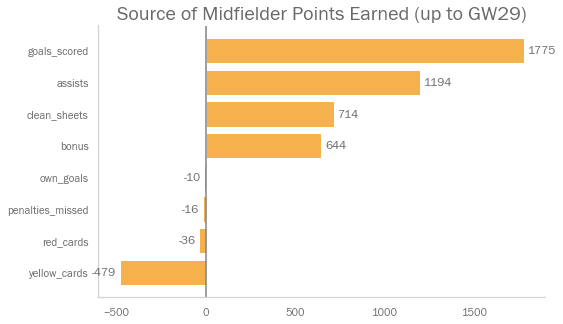

In [20]:
df_temp = df_points.sort_values('MID')['MID'][:-1]
df_temp = df_temp[df_temp!=0]

X = df_temp.index
Y = df_temp

plt.figure(figsize=(8,5))

plt.axvline(0, color='grey')
plt.barh(X,Y,color=color_list[2])
plt.xlim(-600,)

plt.title('Source of Midfielder Points Earned (up to GW29)')

for i, t in enumerate(Y):
    text = f'{t}'
    if t>0:
        plt.text(t+20, i, text, va='center',
                 color='dimgrey', fontsize=12)
    else:
        plt.text(t-20, i, text, va='center', ha='right',
                 color='dimgrey', fontsize=12)

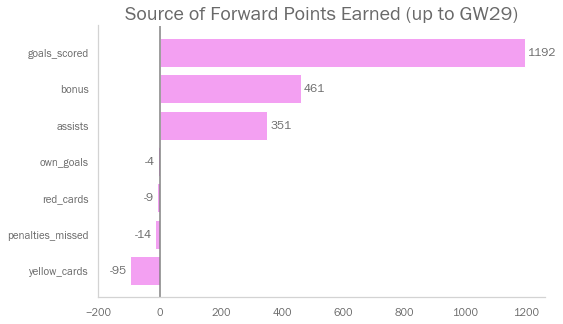

In [21]:
df_temp = df_points.sort_values('FWD')['FWD'][:-1]
df_temp = df_temp[df_temp!=0]

X = df_temp.index
Y = df_temp

plt.figure(figsize=(8,5))

plt.axvline(0, color='grey')
plt.barh(X,Y,color=color_list[3])
plt.xlim(-200,)

plt.title('Source of Forward Points Earned (up to GW29)')

for i, t in enumerate(Y):
    text = f'{t}'
    if t>0:
        plt.text(t+10, i, text, va='center',
                 color='dimgrey', fontsize=12)
    else:
        plt.text(t-10, i, text, va='center', ha='right',
                 color='dimgrey', fontsize=12)